# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from collections import deque
from maddpg_agent import MADDPG

import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

TARGET_SCORE = 0.5

# Training Function

The function is used to train the Agents by interacting with environment and returns the training score. The training is considered to be completed once the Agents achieve a **max average score > 0.5 over 100 episodes**.

In [2]:
def train_agents(n_episodes=5000, num_agents = 2, noise = 2.0, noise_min = 0.01, noise_decay = 0.999):
    scores_deque = deque(maxlen=100)
    scores = []
    avg_scores_l = []

    for i_episode in range(1, n_episodes+1):                                    
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations               
        score = np.zeros(num_agents)

        maddpg_agent.reset()

        while True:
            actions = maddpg_agent.act(states, noise_factor = noise)
            env_info = env.step(actions)[brain_name]            
            next_states = env_info.vector_observations
            rewards = env_info.rewards         
            dones = env_info.local_done                         
            maddpg_agent.step(states, actions, rewards, next_states, dones)        
            states = next_states
            score += rewards  

            if any(dones):                                 
                break
        
        noise = max(noise_decay*noise, noise_min)                    # Decay Noise per Episode
        
        score_max = np.max(score)
        scores.append(score_max)
        scores_deque.append(score_max)
        avg_score = np.mean(scores_deque)
        avg_scores_l.append(avg_score)

        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)), end="")  

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage score: {:.3f}'.format(i_episode , avg_score))

        if avg_score >= TARGET_SCORE:
            maddpg_agent.save_weights()
            print("\rSolved in episode: {} \tAverage score: {:.3f}".format(i_episode , avg_score))
            break
    return scores , avg_scores_l

### 1. Start the Environment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Train the Agent

The cell trains the DQN Agent by utilizing Multi-Agent (2) approach wtih **DDPG Algorithm** that contains the following components:

- Replay Buffer
- Ornstein-Uhlenbeck Process

After the cell is executed, the Agents are trained and the scores of the training are being return for plotting.

In [6]:
maddpg_agent = MADDPG(state_size, action_size, num_agents = 2, seed = 0)

print(maddpg_agent.agents[0].actor_local)
print('\n')
print(maddpg_agent.agents[0].critic_local)
print('\n')
print('Training Starts')
print('===============')

scores, avg_scores = train_agents()

Actor(
  (fc1): Linear(in_features=24, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=150, bias=True)
  (output): Linear(in_features=150, out_features=2, bias=True)
)


Critic(
  (fc1): Linear(in_features=52, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=150, bias=True)
  (output): Linear(in_features=150, out_features=1, bias=True)
)


Training Starts
Episode 100	Average score: 0.001
Episode 200	Average score: 0.003
Episode 300	Average score: 0.001
Episode 400	Average score: 0.008
Episode 500	Average score: 0.034
Episode 600	Average score: 0.063
Episode 700	Average score: 0.040
Episode 800	Average score: 0.107
Episode 900	Average score: 0.280
Solved in episode: 941 	Average score: 0.505


### 4. Plot Agent Scores

The cell below plot the **Scores** and the **Average Scores** that Agent achieved per Episode during training.

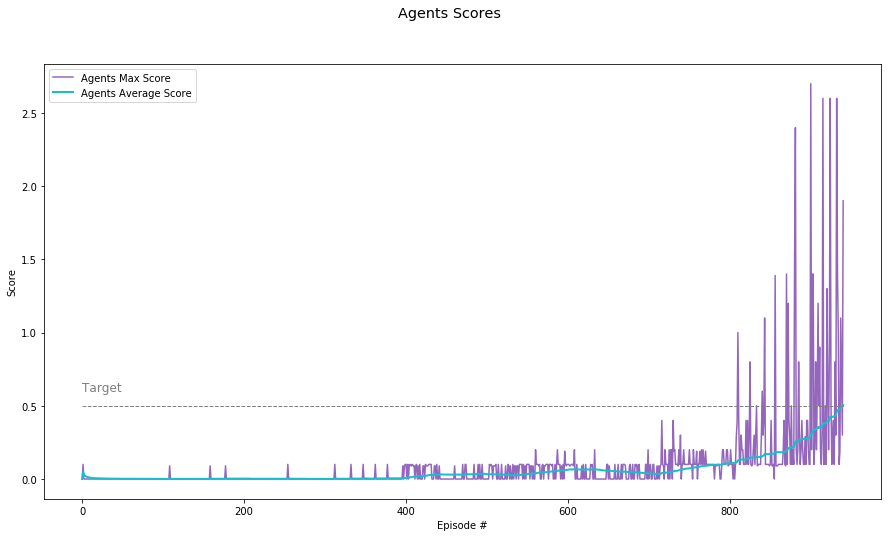

In [18]:
target = [TARGET_SCORE] * len(scores)           # Line for Target

# Plot Agents Scores
fig = plt.figure(figsize=(15,8))
fig.suptitle('Agents Scores', fontsize='x-large')

ax = fig.add_subplot(111)
ax.plot(scores, label='Agents Max Score', color='tab:purple')
ax.plot(avg_scores, label='Agents Average Score', color='tab:cyan', linewidth=2)
ax.plot(target, linestyle='--', color='tab:grey', linewidth=1 )
ax.text(0, TARGET_SCORE+0.1, 'Target', color='tab:grey', fontsize='large')
ax.set_ylabel('Score')
ax.set_xlabel('Episode #')
ax.legend(fontsize='medium', loc='upper left')

plt.show()

When finished, you can close the environment.

In [6]:
env.close()

# Test the Trained Agent

In [5]:
# Test if Environment is Active
try:
    env
except:
    env = UnityEnvironment(file_name='Tennis.app')
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    state_size = states.shape[1]
    action_size = brain.vector_action_space_size
    num_agents = len(env_info.agents)
    
# Initiate MADDPG
maddpg_agent = MADDPG(state_size, action_size, num_agents = 2, seed = 0)

# Load Agent 1
maddpg_agent.agents[0].actor_local.load_state_dict(torch.load('weights/agent1_checkpoint_actor.pth',
                                                              map_location='cpu'))
maddpg_agent.agents[0].critic_local.load_state_dict(torch.load('weights/agent1_checkpoint_critic.pth',
                                                               map_location='cpu'))

# Load Agent 1
maddpg_agent.agents[1].actor_local.load_state_dict(torch.load('weights/agent2_checkpoint_actor.pth',
                                                              map_location='cpu'))
maddpg_agent.agents[1].critic_local.load_state_dict(torch.load('weights/agent2_checkpoint_critic.pth',
                                                               map_location='cpu'))
                          
# Observe Trained Agent in Environment
obs_episodes = 2
scores_episode = np.zeros(num_agents)
for ep in range(1, obs_episodes + 1):
    while True:
        actions = maddpg_agent.act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]
        states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores_episode += rewards
        
        if np.any(dones):
            break

    print('Score for Episode {}: {:.2f}'.format(ep, scores_episode.mean()))

Score for Episode 1: 0.10
Score for Episode 2: 2.70
